# Generated Graph Analysis

This notebook analyzes the generated graphs and compares them against the NDSSL graph.

In [1]:
import os
import itertools
from collections import Counter
from imports import *
#from linkpred import *
#from dataset import *
from torch_geometric.utils import remove_self_loops

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style 
import matplotlib.ticker as mticker
style.use('seaborn-paper')
%matplotlib inline
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

fontsize = 12
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.2e' % x))
fmt = mticker.FuncFormatter(g)
#pd.options.display.float_format = "{:,.3f}".format

/home/gavin/anaconda3/envs/pygeo/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
## set random seeds
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

In [3]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

1.5.1
device = cuda


The `set_node_attributes` function in networkx is [deprecated](https://stackoverflow.com/questions/13698352/storing-and-accessing-node-attributes-python-networkx), so I will use my own fixed function.

In [4]:
def set_node_attributes(G, name, values):
    """Set node attributes from dictionary of nodes and values

    Parameters
    ----------
    G : NetworkX Graph

    name : string
       Attribute name

    values: dict
       Dictionary of attribute values keyed by node. If `values` is not a
       dictionary, then it is treated as a single attribute value that is then
       applied to every node in `G`.

    Examples
    --------
    >>> G = nx.path_graph(3)
    >>> bb = nx.betweenness_centrality(G)
    >>> nx.set_node_attributes(G, 'betweenness', bb)
    >>> G.node[1]['betweenness']
    1.0
    """
    try:
        values.items
    except AttributeError:
        # Treat `value` as the attribute value for each node.
        values = dict(zip(G.nodes(), [values] * len(G)))

    for node, value in values.items():
        G.nodes[node][name] = value

## Load the Data

### Load the NDSSL Data

In [5]:
node_attributes = pd.read_csv('data/NDSSL data/raw/node_attributes.csv')
# add a new variable corresponding to the binned ages
age_binned = (node_attributes['age'].values)/10
age_binned = age_binned.astype(np.int64)
node_attributes['age_binned'] = age_binned

column_names = list(node_attributes.columns)[2:]

ndssl = load_dataset(dataset_name='NDSSL')
data_ndssl = ndssl[0]
G_ndssl = nx.Graph()
G_ndssl.add_edges_from([(j,j) for j in range(len(node_attributes))]) #add then remove self-loops to ensure that every node is present
G_ndssl.add_edges_from(tuple(map(tuple, np.transpose(data_ndssl.edge_index.numpy()))))
G_ndssl.remove_edges_from([(j,j) for j in range(len(node_attributes))])    

# add the node attributes
for name in column_names:
    set_node_attributes(G_ndssl, name, node_attributes.to_dict()[name])

### Load the Generated Data

In [6]:
epochs = 300
nlist = [1000, 10000, 100000]
N_outer = 100000
linkpred_epochs = 600

#init_type = 'scale-free'
#init_type = 'const-density'
init_type = 'const-edge-node-ratio'
#init_type = 'fractional scaling'
#init_type = 'small-world'

In [7]:
Ginitial_list = []
Gfinal_list = []
node_attribute_list = []

for i in range(len(nlist)):
    
    n = nlist[i]

    # load the node attribute data
    load_path = 'generated/df_artificial_n_' + str(n) + '_ctgan_epochs_' + str(epochs) + '.pt'
    node_attribute_list.append(np.load(load_path, allow_pickle=True))
    
    age_binned = (node_attribute_list[-1]['age'].values)/10
    age_binned = age_binned.astype(np.int64)
    node_attribute_list[-1]['age_binned'] = age_binned

    # load the initial graph
    load_path = 'generated/edge_index_initial_' + init_type + '_n_' + str(n) + '.pt'
    edge_index = torch.load(load_path)
    G = nx.Graph()
    G.add_edges_from([(j,j) for j in range(n)]) #add then remove self-loops to ensure that every node is present
    G.add_edges_from(tuple(map(tuple, np.transpose(edge_index.numpy()))))
    G.remove_edges_from([(j,j) for j in range(n)])        
    # add the node attributes
    for name in column_names:
        set_node_attributes(G, name, node_attribute_list[-1].to_dict()[name])
    Ginitial_list.append(G)
    
    # load the final graph
    load_path = 'generated/edge_index_final_' + init_type + '_n_' + str(n) + '_ctgan_epochs_' + str(epochs) \
        + '_iterations_' + str(N_outer) + '_linkpred_epochs_' + str(linkpred_epochs) + '.pt'
    edge_index = torch.load(load_path)
    G = nx.Graph()
    G.add_edges_from([(j,j) for j in range(n)]) #add then remove self-loops to ensure that every node is present
    G.add_edges_from(tuple(map(tuple, np.transpose(edge_index.numpy()))))
    G.remove_edges_from([(j,j) for j in range(n)])
    # add the node attributes
    for name in column_names:
        set_node_attributes(G, name, node_attribute_list[-1].to_dict()[name])
    Gfinal_list.append(G)

## Analysis

Compare the generated graphs against the true NDSSL network.

### Network Statistics

Giant component sizes. These are smaller than the corresponding $N$ values because the rewiring algorithm created some isolates.

In [8]:
tmp = {}
for i in range(len(nlist)):
    G = Ginitial_list[i]
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    tmp['Init ' + str(nlist[i])] = [len(G0.nodes)]

    G = Gfinal_list[i]
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    tmp['Gen ' + str(nlist[i])] = [len(G0.nodes)]

G = G_ndssl
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
tmp['NDSSL'] = [len(G0.nodes)]

df_stats = pd.DataFrame.from_dict(tmp)
df_stats.index = ['Gcc size'] 

The degree distribution

In [9]:
means = []
quantile25s = []
quantile50s = []
quantile75s = []
mins = []
maxs = []

for i in range(len(nlist)):
    
    degree_sequence = np.asarray(sorted([d for n, d in Ginitial_list[i].degree()], reverse=False))
    degree_counter = Counter(degree_sequence)
    del degree_counter[0] #remove isolates
    means.append(np.mean(degree_sequence))
    quantile25s.append(np.quantile(degree_sequence, 0.25))
    quantile50s.append(np.quantile(degree_sequence, 0.5))
    quantile75s.append(np.quantile(degree_sequence, 0.75))
    mins.append(np.min(degree_sequence))
    maxs.append(np.max(degree_sequence))

    degree_sequence = np.asarray(sorted([d for n, d in Gfinal_list[i].degree()], reverse=False))
    degree_counter = Counter(degree_sequence)
    del degree_counter[0] #remove isolates
    means.append(np.mean(degree_sequence))
    quantile25s.append(np.quantile(degree_sequence, 0.25))
    quantile50s.append(np.quantile(degree_sequence, 0.5))
    quantile75s.append(np.quantile(degree_sequence, 0.75))
    mins.append(np.min(degree_sequence))
    maxs.append(np.max(degree_sequence))

degree_sequence = np.asarray(sorted([d for n, d in G_ndssl.degree()], reverse=False))
degree_counter = Counter(degree_sequence)
del degree_counter[0] #remove isolates
means.append(np.mean(degree_sequence))
quantile25s.append(np.quantile(degree_sequence, 0.25))
quantile50s.append(np.quantile(degree_sequence, 0.5))
quantile75s.append(np.quantile(degree_sequence, 0.75))
mins.append(np.min(degree_sequence))
maxs.append(np.max(degree_sequence))

df_stats.loc['k means'] = means
df_stats.loc['k quantile25s'] = quantile25s
df_stats.loc['k quantile50s'] = quantile50s
df_stats.loc['k quantile75s'] = quantile75s
df_stats.loc['k mins'] = mins
df_stats.loc['k maxs'] = maxs

Triangles

In [10]:
triangles = []
for i in range(len(nlist)):
    triangles.append(np.sum(list(nx.triangles(Ginitial_list[i]).values())))
    triangles.append(np.sum(list(nx.triangles(Gfinal_list[i]).values())))    
triangles.append(388850385)

df_stats.loc['num triangles'] = triangles

In [11]:
df_stats

,Init 1000,Gen 1000,Init 10000,Gen 10000,Init 100000,Gen 100000,NDSSL
Gcc size,1000.000,880.000,10000.0000,9551.000,100000.00000,86302.00000,1.539920e+06
k means,24.352,17.344,24.6926,33.243,24.72208,24.75972,2.433181e+01
k quantile25s,21.000,9.000,21.0000,25.000,21.00000,15.00000,5.000000e+00
k quantile50s,24.000,16.000,24.0000,34.000,25.00000,27.00000,1.900000e+01
k quantile75s,28.000,25.000,28.0000,43.000,28.00000,35.00000,3.600000e+01
k mins,9.000,0.000,7.0000,0.000,6.00000,0.00000,0.000000e+00
k maxs,40.000,66.000,44.0000,82.000,50.00000,91.00000,2.930000e+02
num triangles,7374.000,40326.000,7428.0000,38772.000,7680.00000,25767.00000,3.888504e+08


### Ego-centric Visualizations

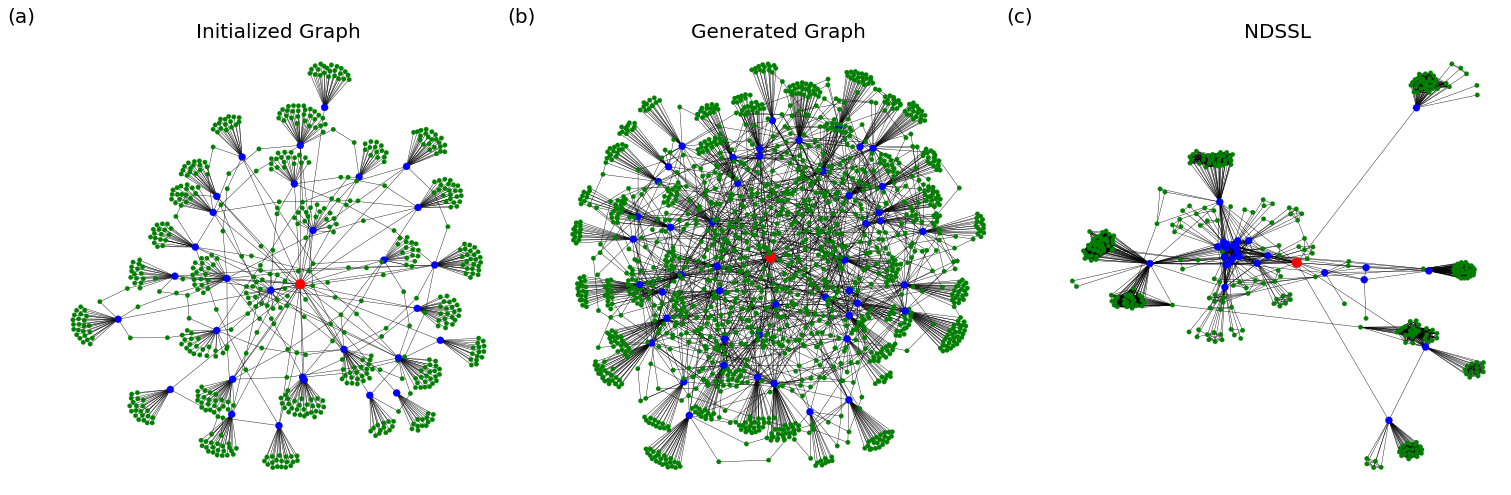

In [12]:
## set a random seed
random.seed(a=1)
np.random.seed(1)

## the size and color of the nodes is determined by their distance from the root node
color_key = {0:'red', 1:'blue', 2:'green'}
size_key = {0:100, 1:50, 2:20}

fig, axarr = plt.subplots(1, 3, figsize=(21, 7))
#fig.subplots_adjust(wspace=0.3)
#st = plt.suptitle('Individual Demographic Data', fontsize=16)

axarr[0].text(-0.1, 1.05, '(a)', transform=axarr[0].transAxes, size=20)
axarr[1].text(-0.1, 1.05, '(b)', transform=axarr[1].transAxes, size=20)
axarr[2].text(-0.1, 1.05, '(c)', transform=axarr[2].transAxes, size=20)

ax = axarr[0]
G = Ginitial_list[-1]
root = random.choice(list(G.nodes))
edges = nx.bfs_edges(G, root, depth_limit=2)
nodes = [root] + [v for u, v in edges]
subgraph = G.subgraph(nodes)
node_colors = [ color_key[nx.shortest_path_length(subgraph, source=root, target=list(subgraph.nodes())[i])] \
               for i in range(len(list(subgraph.nodes())))]
node_sizes = [ size_key[nx.shortest_path_length(subgraph, source=root, target=list(subgraph.nodes())[i])] for i in range(len(list(subgraph.nodes())))]
nx.draw_spring(subgraph, node_size=node_sizes, width=0.4, node_color=node_colors, ax=ax)
ax.set_title('Initialized Graph', fontsize=20)

ax = axarr[1]
G = Gfinal_list[-1]
root = random.choice(list(G.nodes))
edges = nx.bfs_edges(G, root, depth_limit=2)
nodes = [root] + [v for u, v in edges]
subgraph = G.subgraph(nodes)
node_colors = [ color_key[nx.shortest_path_length(subgraph, source=root, target=list(subgraph.nodes())[i])] \
               for i in range(len(list(subgraph.nodes())))]
node_sizes = [ size_key[nx.shortest_path_length(subgraph, source=root, target=list(subgraph.nodes())[i])] for i in range(len(list(subgraph.nodes())))]
nx.draw_spring(subgraph, node_size=node_sizes, width=0.4, node_color=node_colors, ax=ax)
ax.set_title('Generated Graph', fontsize=20)

ax = axarr[2]
G = G_ndssl
root = random.choice(list(G.nodes))
edges = nx.bfs_edges(G, root, depth_limit=2)
nodes = [root] + [v for u, v in edges]
subgraph = G.subgraph(nodes)
node_colors = [ color_key[nx.shortest_path_length(subgraph, source=root, target=list(subgraph.nodes())[i])] \
               for i in range(len(list(subgraph.nodes())))]
node_sizes = [ size_key[nx.shortest_path_length(subgraph, source=root, target=list(subgraph.nodes())[i])] for i in range(len(list(subgraph.nodes())))]
nx.draw_spring(subgraph, node_size=node_sizes, width=0.4, node_color=node_colors, ax=ax)
ax.set_title('NDSSL', fontsize=20)

fig.tight_layout() 
plt.savefig('figures/egocentric_comparison.pdf')    
plt.show()

### Degree Distribution

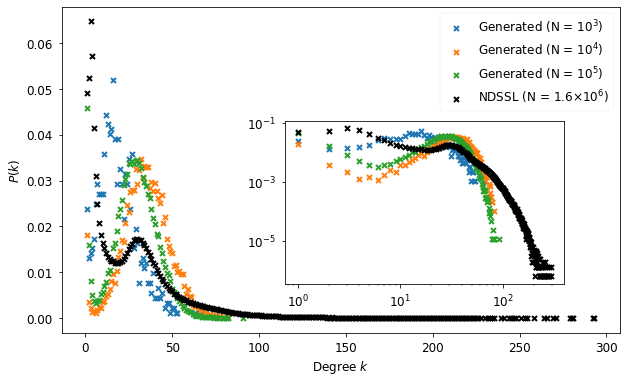

In [13]:
s = 25
marker = 'x'
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.4,0.15,0.5,0.5])
ax2.set_axes_locator(ip)

for i in range(len(nlist)):
    

    degree_sequence = np.asarray(sorted([d for n, d in Gfinal_list[i].degree()], reverse=False))
    degree_counter = Counter(degree_sequence)
    del degree_counter[0] #remove isolates
    degree_values = np.asarray(list(degree_counter.values()))
    degree_values = degree_values/np.sum(degree_values)
    ax1.scatter(list(degree_counter.keys()), degree_values, alpha=1, linewidth=2, s=s, marker=marker, \
            label="Generated (N = {})".format(fmt(nlist[i])), color=color_cycle[i])

    ax2.scatter(list(degree_counter.keys()), degree_values, alpha=1, linewidth=2, s=s, marker=marker, \
        label="Generated (N = {})".format(fmt(nlist[i])), color=color_cycle[i])

degree_sequence = np.asarray(sorted([d for n, d in G_ndssl.degree()], reverse=False))
degree_counter = Counter(degree_sequence)
del degree_counter[0] #remove isolates
degree_values = np.asarray(list(degree_counter.values()))
degree_values = degree_values/np.sum(degree_values)
ax1.scatter(list(degree_counter.keys()), degree_values, alpha=1, linewidth=2 \
            , s=s, marker=marker, label="NDSSL (N = {})".format(fmt(len(G_ndssl))), color='k')
    
ax2.scatter(list(degree_counter.keys()), degree_values, alpha=1, linewidth=2 \
            , s=s, marker=marker, label="NDSSL (N = {})".format(fmt(len(G_ndssl))), color='k')
    
ax2.set_xscale('log')
ax2.set_yscale('log')
#plt.title("Degree")
ax1.set_ylabel(r'$P(k)$')
ax1.set_xlabel(r'Degree $k$')
ax1.legend()
plt.savefig('figures/graph_generation_degree.pdf')
plt.show()

### Degree Correlation Spectrum $k_{nn}(k)$

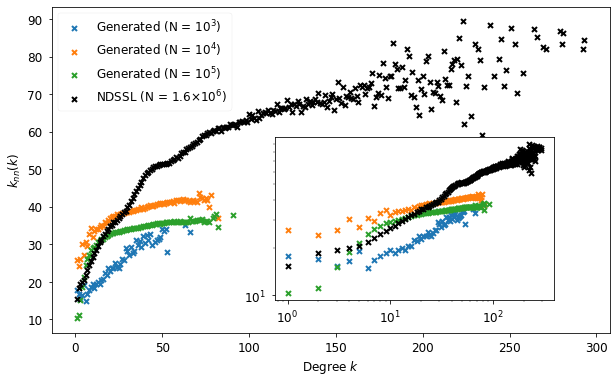

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.4,0.1,0.5,0.5])
ax2.set_axes_locator(ip)

for i in range(len(nlist)):
    knn_dict = nx.k_nearest_neighbors(Gfinal_list[i])
    del knn_dict[0] #remove isolates    
    k = np.asarray(list(knn_dict.keys()))
    knn = np.asarray(list(knn_dict.values()))
    ax1.scatter(k, knn, alpha=1, linewidth=2, s=s, marker=marker, \
                label="Generated (N = {})".format(fmt(nlist[i])), color=color_cycle[i])
    ax2.scatter(k, knn, alpha=1, linewidth=2, s=s, marker=marker, \
                label="Generated (N = {})".format(fmt(nlist[i])), color=color_cycle[i])
    
knn_dict = nx.k_nearest_neighbors(G_ndssl)
del knn_dict[0] #remove isolates    
k = np.asarray(list(knn_dict.keys()))
knn = np.asarray(list(knn_dict.values()))
ax1.scatter(k, knn, alpha=1, linewidth=2, s=s, marker=marker, \
            label="NDSSL (N = {})".format(fmt(len(G_ndssl))), color='k')
ax2.scatter(k, knn, alpha=1, linewidth=2, s=s, marker=marker, \
            label="NDSSL (N = {})".format(fmt(len(G_ndssl))), color='k')

ax1.set_xlabel(r'Degree $k$')
ax1.set_ylabel(r'$k_{nn}(k)$')
ax1.legend()
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.savefig('figures/graph_generation_assortive_mixing.pdf')
plt.show()

### Clustering

The clustering is awful because the generated networks have such fewer triangles

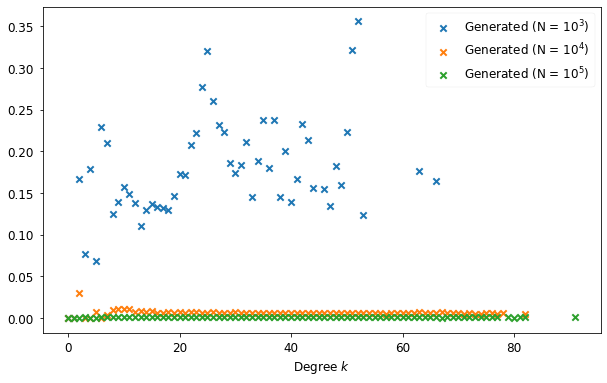

In [15]:
s = 40
marker = 'x'
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(nlist)):

    degrees = np.asarray(list(Gfinal_list[i].degree))[:,1]
    clusteringcoeffs = np.asarray(list(nx.clustering(Gfinal_list[i]).values()))
    clusteringcoeff_avg = [np.mean(clusteringcoeffs[degrees == k]) for k in np.sort(np.unique(degrees))]

    ax.scatter(np.sort(np.unique(degrees)), clusteringcoeff_avg, alpha=1, linewidth=2, s=s, marker=marker, \
            label="Generated (N = {})".format(fmt(nlist[i])), color=color_cycle[i])
    
    
#degrees = np.asarray(list(G_ndssl.degree))[:,1]
#clusteringcoeffs = np.asarray(list(nx.clustering(G_ndssl).values()))
#clusteringcoeff_avg = [np.mean(clusteringcoeffs[degrees == k]) for k in np.sort(np.unique(degrees))]

#ax.scatter(np.sort(np.unique(degrees)), clusteringcoeff_avg, alpha=1, linewidth=2, s=s, marker=marker, \
        #label="NDSSL (N = {})".format(fmt(len(G_ndssl))), color='k')

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'Degree $k$')
plt.legend()
plt.savefig('figures/graph_generation_clustering.pdf')
plt.show()

### Mixing Matrices

In [16]:
column_labels = {
    'gender': ['Male', 'Female'],
    'worker': ['Employed', 'Unemployed'],
    'household_income': ['0-5k', '5-10k', '10-15k', '15-20k', '20-25k', '25-30k', \
                         '30-35k', '35-40k', '40-45k', '45-50k', '50-55k', '55-60k', '60k-', 'N/A'],
    'age_binned':['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
}


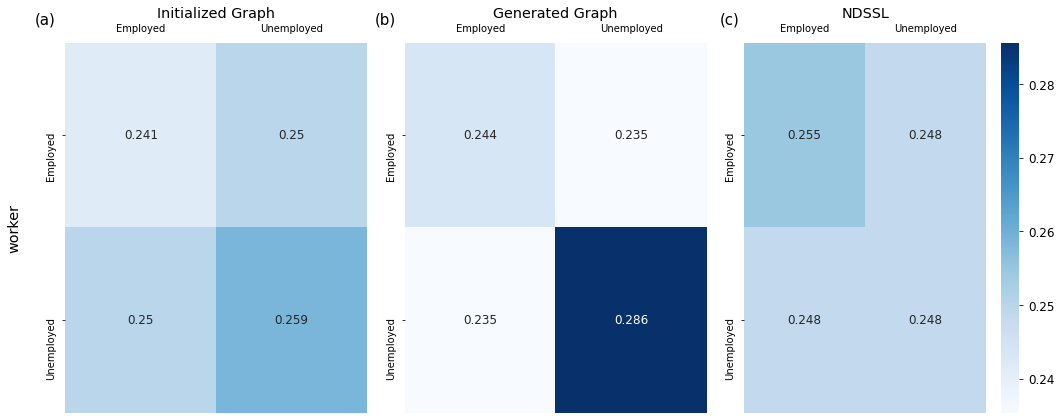

In [30]:
attribute = 'worker'
ls = 10
color = (0, 0, 0)

fig, axarr = plt.subplots(1, 3, figsize=(15, 6))

axarr[0].text(-0.1, 1.05, '(a)', transform=axarr[0].transAxes, size=15)
axarr[1].text(-0.1, 1.05, '(b)', transform=axarr[1].transAxes, size=15)
axarr[2].text(-0.1, 1.05, '(c)', transform=axarr[2].transAxes, size=15)

# data
xinit = pd.DataFrame(nx.attribute_mixing_matrix(Ginitial_list[-1], attribute), )
xinit.columns = column_labels[attribute]
xinit.index = xinit.columns

xfinal = pd.DataFrame(nx.attribute_mixing_matrix(Gfinal_list[-1], attribute), )
xfinal.columns = column_labels[attribute]
xfinal.index = xfinal.columns

xndssl = pd.DataFrame(nx.attribute_mixing_matrix(G_ndssl, attribute), )
xndssl.columns = column_labels[attribute]
xndssl.index = xndssl.columns

vmin = np.minimum(np.minimum(np.min(xinit.to_numpy()), np.min(xfinal.to_numpy())), np.min(xndssl.to_numpy()))
vmax = np.maximum(np.maximum(np.max(xinit.to_numpy()), np.max(xfinal.to_numpy())), np.max(xndssl.to_numpy()))

# plot
ax = axarr[0]
sns.heatmap(xinit, annot=True, cmap='Blues', fmt='.3g', cbar=False, ax=ax, vmin=vmin, vmax=vmax)#, annot_kws={"color":color})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

ax = axarr[1]
sns.heatmap(xfinal, annot=True, cmap='Blues', fmt='.3g', cbar=False, ax=ax, vmin=vmin, vmax=vmax)#, annot_kws={"color":color})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

ax = axarr[2]
sns.heatmap(xndssl, annot=True, cmap='Blues', fmt='.3g', cbar=True, ax=ax, vmin=vmin, vmax=vmax)#, annot_kws={"color":color})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

# label the rows/columns
cols = ['Initialized Graph', 'Generated Graph', 'NDSSL']
rows = attribute
#for ax, col in zip(axarr[0], cols):
#    ax.set_title(col, size='large', pad=25)
#for ax, row in zip(axarr[:,0], rows):
#    ax.set_ylabel(row, rotation=90, size='large', labelpad=25)
for ax, col in zip(axarr, cols):
    ax.set_title(col, size='large', pad=25) 
axarr[0].set_ylabel(attribute, rotation=90, size='large', labelpad=25)

fig.tight_layout()    
plt.savefig('figures/worker_mixing_matrix.pdf')
plt.show()

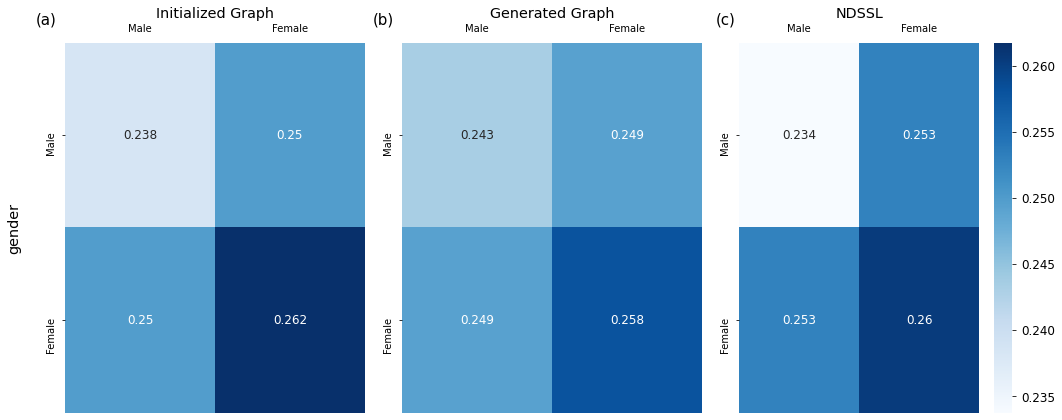

In [29]:
attribute = 'gender'
ls = 10
color = (0, 0, 0)

fig, axarr = plt.subplots(1, 3, figsize=(15, 6))

axarr[0].text(-0.1, 1.05, '(a)', transform=axarr[0].transAxes, size=15)
axarr[1].text(-0.1, 1.05, '(b)', transform=axarr[1].transAxes, size=15)
axarr[2].text(-0.1, 1.05, '(c)', transform=axarr[2].transAxes, size=15)

# data
xinit = pd.DataFrame(nx.attribute_mixing_matrix(Ginitial_list[-1], attribute), )
xinit.columns = column_labels[attribute]
xinit.index = xinit.columns

xfinal = pd.DataFrame(nx.attribute_mixing_matrix(Gfinal_list[-1], attribute), )
xfinal.columns = column_labels[attribute]
xfinal.index = xfinal.columns

xndssl = pd.DataFrame(nx.attribute_mixing_matrix(G_ndssl, attribute), )
xndssl.columns = column_labels[attribute]
xndssl.index = xndssl.columns

vmin = np.minimum(np.minimum(np.min(xinit.to_numpy()), np.min(xfinal.to_numpy())), np.min(xndssl.to_numpy()))
vmax = np.maximum(np.maximum(np.max(xinit.to_numpy()), np.max(xfinal.to_numpy())), np.max(xndssl.to_numpy()))

# plot
ax = axarr[0]
sns.heatmap(xinit, annot=True, cmap='Blues', fmt='.3g', cbar=False, ax=ax, vmin=vmin, vmax=vmax)#, annot_kws={"color":color})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

ax = axarr[1]
sns.heatmap(xfinal, annot=True, cmap='Blues', fmt='.3g', cbar=False, ax=ax, vmin=vmin, vmax=vmax)#, annot_kws={"color":color})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

ax = axarr[2]
sns.heatmap(xndssl, annot=True, cmap='Blues', fmt='.3g', cbar=True, ax=ax, vmin=vmin, vmax=vmax)#, annot_kws={"color":color})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

# label the rows/columns
#cols = ['Initialized Graph', 'Generated Graph', 'NDSSL']
rows = attribute
#for ax, col in zip(axarr[0], cols):
#    ax.set_title(col, size='large', pad=25)
#for ax, row in zip(axarr[:,0], rows):
#    ax.set_ylabel(row, rotation=90, size='large', labelpad=25)
for ax, col in zip(axarr, cols):
    ax.set_title(col, size='large', pad=25) 
axarr[0].set_ylabel(attribute, rotation=90, size='large', labelpad=25)
       
fig.tight_layout()    
plt.savefig('figures/gender_mixing_matrix.pdf')    
plt.show()

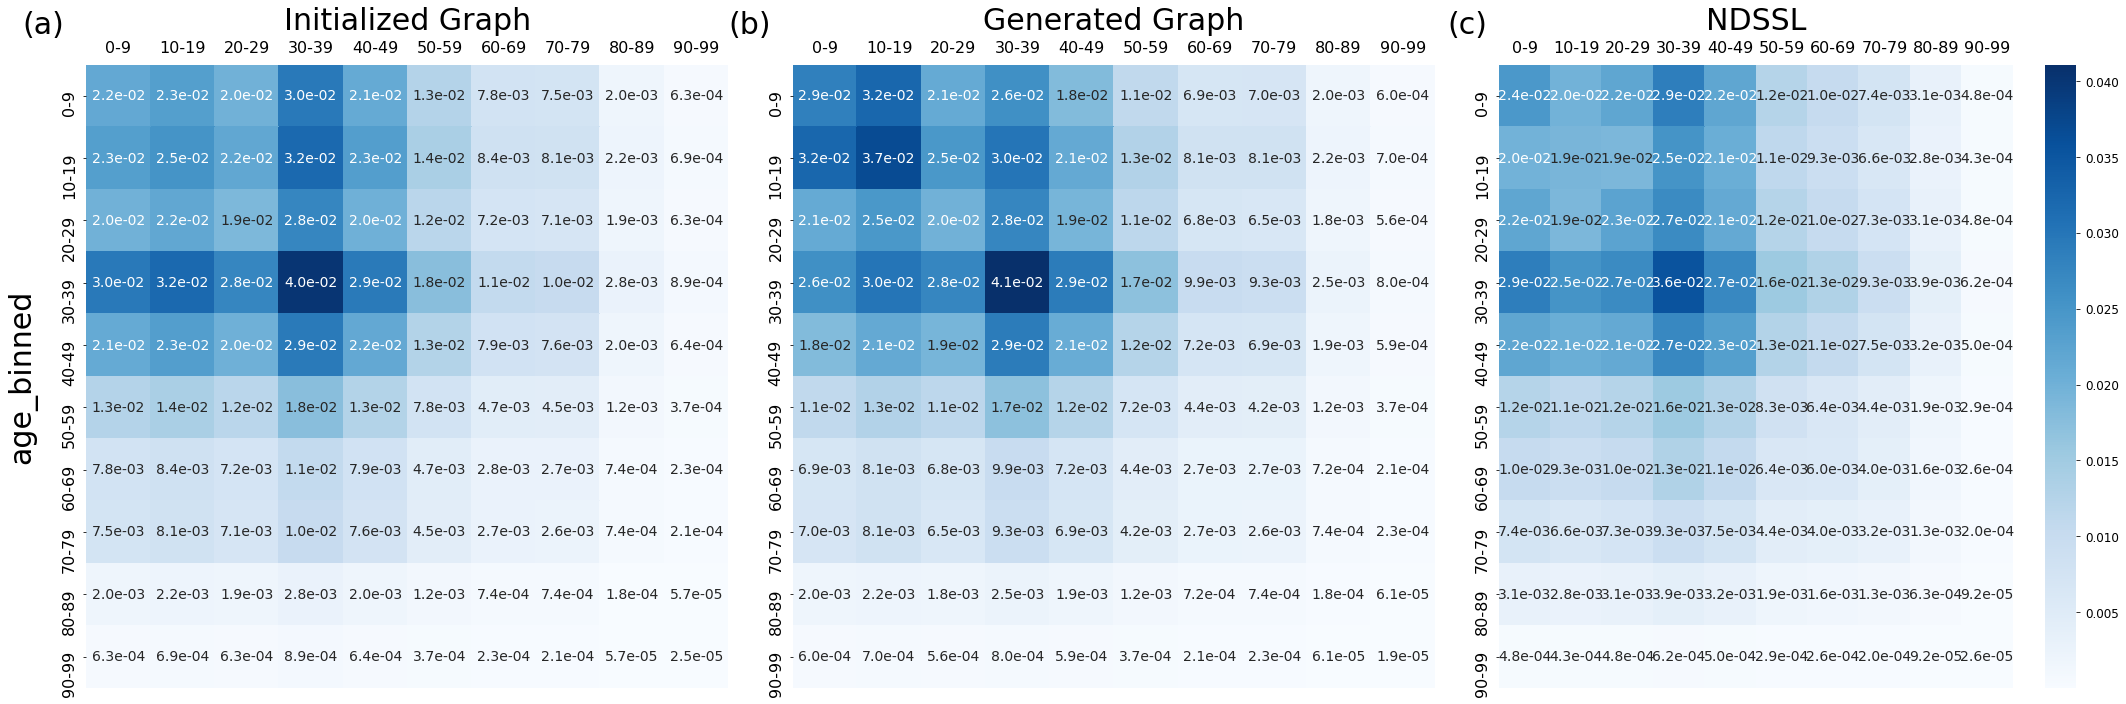

In [31]:
attribute = 'age_binned'
ls = 16
msize = 14
color = (0, 0, 0)

fig, axarr = plt.subplots(1, 3, figsize=(30, 10))

axarr[0].text(-0.1, 1.05, '(a)', transform=axarr[0].transAxes, size=30)
axarr[1].text(-0.1, 1.05, '(b)', transform=axarr[1].transAxes, size=30)
axarr[2].text(-0.1, 1.05, '(c)', transform=axarr[2].transAxes, size=30)

# data
xinit = pd.DataFrame(nx.attribute_mixing_matrix(Ginitial_list[-1], attribute), )
xinit.columns = column_labels[attribute]
xinit.index = xinit.columns

xfinal = pd.DataFrame(nx.attribute_mixing_matrix(Gfinal_list[-1], attribute), )
xfinal.columns = column_labels[attribute]
xfinal.index = xfinal.columns

xndssl = pd.DataFrame(nx.attribute_mixing_matrix(G_ndssl, attribute), )
xndssl.columns = column_labels[attribute]
xndssl.index = xndssl.columns

vmin = np.minimum(np.minimum(np.min(xinit.to_numpy()), np.min(xfinal.to_numpy())), np.min(xndssl.to_numpy()))
vmax = np.maximum(np.maximum(np.max(xinit.to_numpy()), np.max(xfinal.to_numpy())), np.max(xndssl.to_numpy()))

# plot
ax = axarr[0]
sns.heatmap(xinit, annot=True, cmap='Blues', fmt='.1e', cbar=False, ax=ax, vmin=vmin, vmax=vmax, annot_kws={"size": msize})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

ax = axarr[1]
sns.heatmap(xfinal, annot=True, cmap='Blues', fmt='.1e', cbar=False, ax=ax, vmin=vmin, vmax=vmax, annot_kws={"size": msize})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

ax = axarr[2]
sns.heatmap(xndssl, annot=True, cmap='Blues', fmt='.1e', cbar=True, ax=ax, vmin=vmin, vmax=vmax, annot_kws={"size": msize})
ax.tick_params(axis='both', which='major', labelsize=ls, labelbottom = False, bottom=False, top = False, labeltop=True)

# label the rows/columns
cols = ['Initialized Graph', 'Generated Graph', 'NDSSL']
rows = attribute
#for ax, col in zip(axarr[0], cols):
#    ax.set_title(col, size='large', pad=25)
#for ax, row in zip(axarr[:,0], rows):
#    ax.set_ylabel(row, rotation=90, size='large', labelpad=25)
for ax, col in zip(axarr, cols):
    ax.set_title(col, size=30, pad=35) 
axarr[0].set_ylabel(attribute, rotation=90, size=30, labelpad=25)

fig.tight_layout()    
plt.savefig('figures/age_binned_mixing_matrix.pdf')            
plt.show()

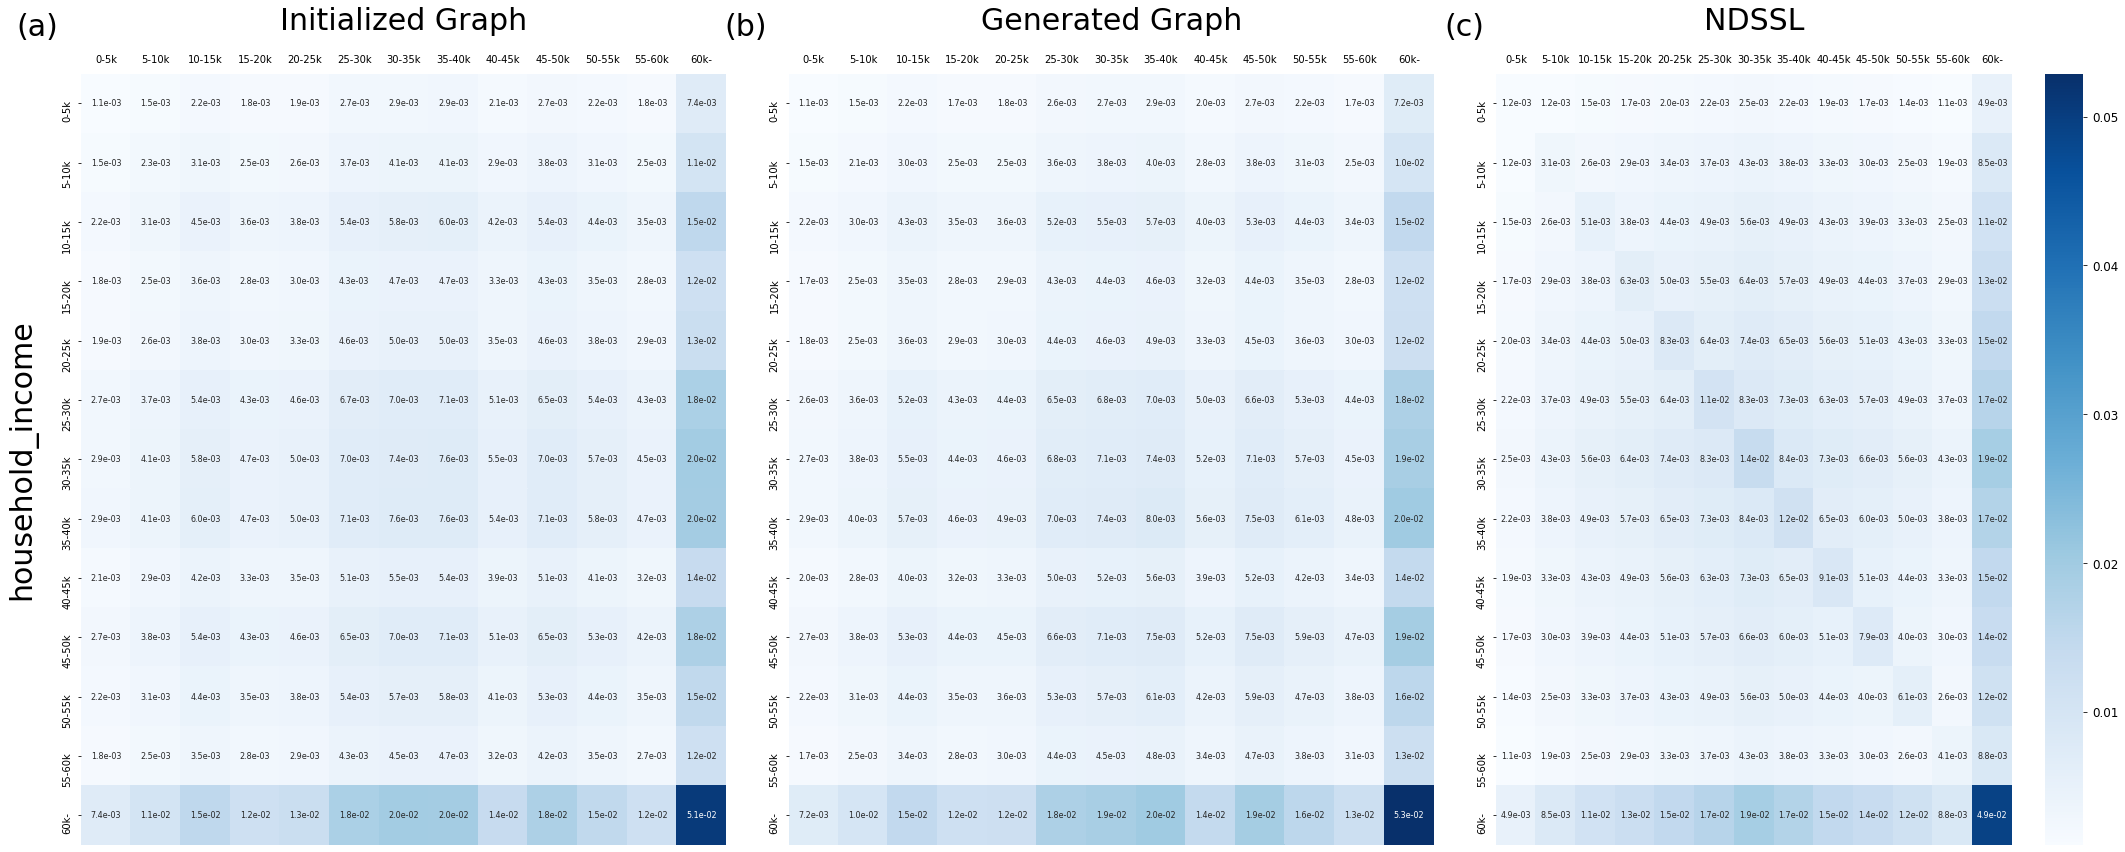

In [21]:
attribute = 'household_income'

fig, axarr = plt.subplots(1, 3, figsize=(30, 12))
axarr[0].text(-0.1, 1.05, '(a)', transform=axarr[0].transAxes, size=30)
axarr[1].text(-0.1, 1.05, '(b)', transform=axarr[1].transAxes, size=30)
axarr[2].text(-0.1, 1.05, '(c)', transform=axarr[2].transAxes, size=30)

# data
xinit = pd.DataFrame(nx.attribute_mixing_matrix(Ginitial_list[-1], attribute), ).iloc[:-1,:-1]
xinit.columns = column_labels[attribute][:-1]
xinit.index = xinit.columns

xfinal = pd.DataFrame(nx.attribute_mixing_matrix(Gfinal_list[-1], attribute), ).iloc[:-1,:-1]
xfinal.columns = column_labels[attribute][:-1]
xfinal.index = xfinal.columns

xndssl = pd.DataFrame(nx.attribute_mixing_matrix(G_ndssl, attribute), ).iloc[:-1,:-1]
xndssl.columns = column_labels[attribute][:-1]
xndssl.index = xndssl.columns

vmin = np.minimum(np.minimum(np.min(xinit.to_numpy()), np.min(xfinal.to_numpy())), np.min(xndssl.to_numpy()))
vmax = np.maximum(np.maximum(np.max(xinit.to_numpy()), np.max(xfinal.to_numpy())), np.max(xndssl.to_numpy()))

# plot
ax = axarr[0]
sns.heatmap(xinit, annot=True, cmap='Blues', fmt='.1e', cbar=False, ax=ax, vmin=vmin, vmax=vmax, annot_kws={"size": 8})
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

ax = axarr[1]
sns.heatmap(xfinal, annot=True, cmap='Blues', fmt='.1e', cbar=False, ax=ax, vmin=vmin, vmax=vmax, annot_kws={"size": 8})
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

ax = axarr[2]
sns.heatmap(xndssl, annot=True, cmap='Blues', fmt='.1e', cbar=True, ax=ax, vmin=vmin, vmax=vmax, annot_kws={"size": 8})
ax.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

# label the rows/columns
cols = ['Initialized Graph', 'Generated Graph', 'NDSSL']
rows = attribute
#for ax, col in zip(axarr[0], cols):
#    ax.set_title(col, size='large', pad=25)
#for ax, row in zip(axarr[:,0], rows):
#    ax.set_ylabel(row, rotation=90, size='large', labelpad=25)
for ax, col in zip(axarr, cols):
    ax.set_title(col, size=30, pad=25) 
axarr[0].set_ylabel(attribute, rotation=90, size=30, labelpad=25)

fig.tight_layout()    
plt.savefig('figures/income_mixing_matrix.pdf')            
plt.show()